## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

In [14]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib qt

### Briefly state how you computed the camera matrix and distortion coefficients. Provide an example of a distortion corrected calibration image.

OpenCV functions or other methods were used to calculate the correct camera matrix and distortion coefficients using the calibration chessboard images provided in the repository (note these are 9x6 chessboard images, unlike the 8x6 images used in the lesson). The distortion matrix should be used to un-distort one of the calibration images provided as a demonstration that the calibration is correct. Example of undistorted calibration image is Included in the writeup (or saved to a folder).

In [12]:
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')
#images = 'camera_cal/calibration1.jpg'
# Step through the list and search for chessboard corners
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        cv2.drawChessboardCorners(img, (9,6), corners, ret)
        write_name = 'corners_found'+str(idx)+'.jpg'
        cv2.imwrite(write_name, img)

Text(0.5, 1.0, 'Undistorted Image')

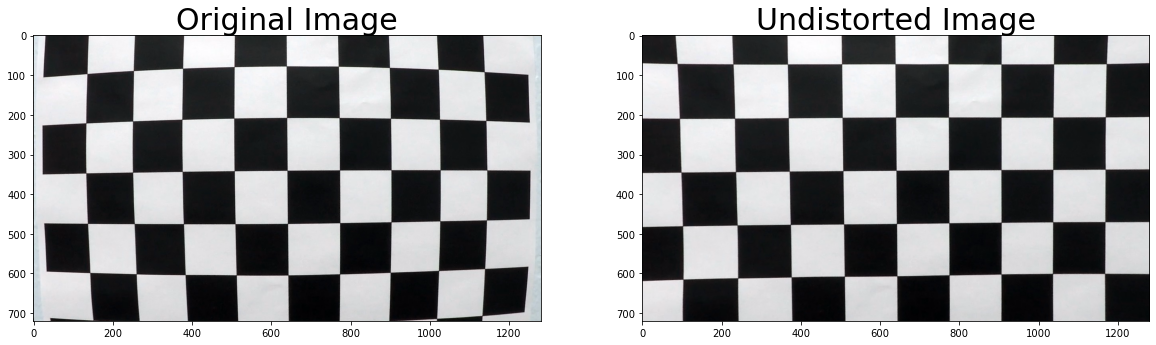

In [13]:
import pickle
%matplotlib inline

# Test undistortion on an image
img = cv2.imread('camera_cal/calibration1.jpg')
img_size = (img.shape[1], img.shape[0])

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)


dst = cv2.undistort(img, mtx, dist, None, mtx)
cv2.imwrite('camera_cal/test_undist.jpg',dst)

# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "camera_cal/wide_dist_pickle.p", "wb" ) )
#dst = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)
# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)

### Describe how (and identify where in your code) you used color transforms, gradients or other methods to create a thresholded binary image. Provide an example of a binary image result.

A method or combination of methods (i.e., color transforms, gradients) has been used to create a binary image containing likely lane pixels. There is no "ground truth" here, just visual verification that the pixels identified as part of the lane lines are, in fact, part of the lines. Example binary images should be included in the writeup (or saved to a folder) and submitted with the project.

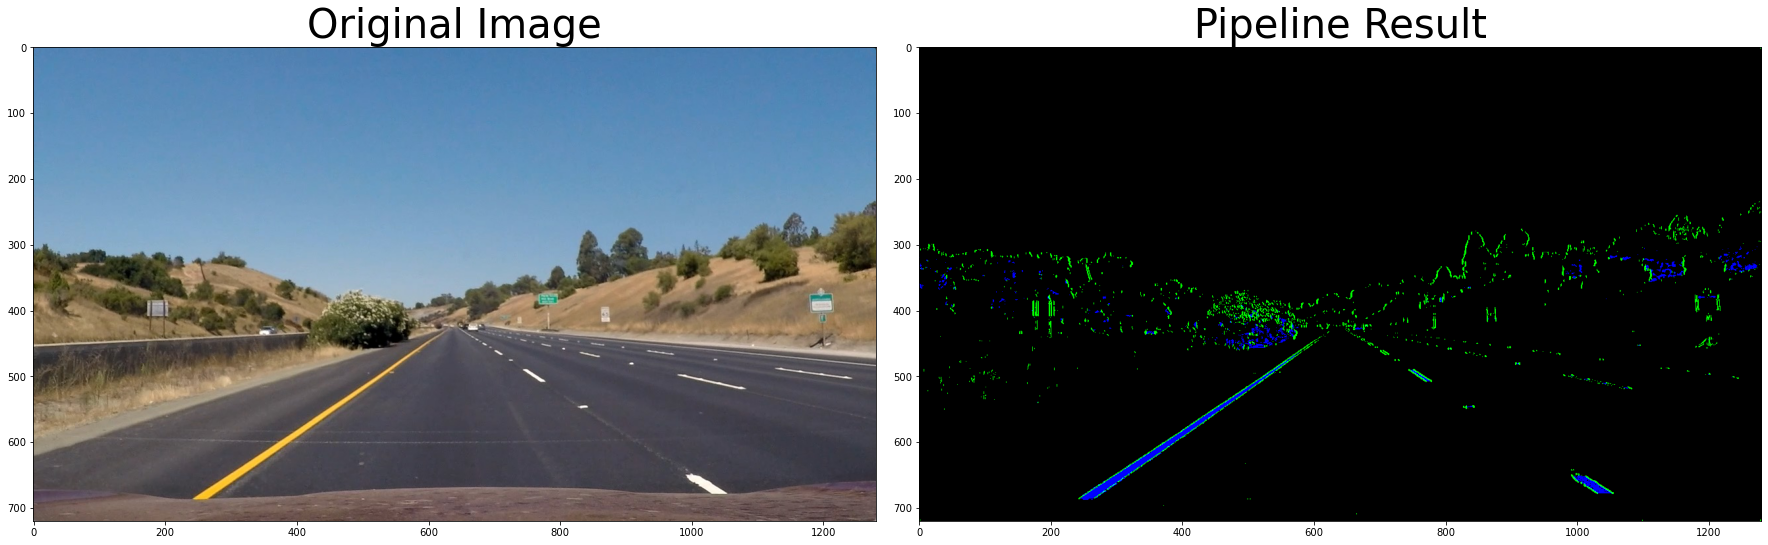

In [210]:

image = mpimg.imread('test_images/straight_lines1.jpg')

# Edit this function to create your own pipeline.
def pipeline(img, s_thresh=(170, 255), sx_thresh=(50, 250),sy_thresh=(50, 100)):
    img = np.copy(img)
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0,ksize=3) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Sobel y
    sobely = cv2.Sobel(l_channel, cv2.CV_64F, 0, 1,ksize=3) # Take the derivative in y
    abs_sobely = np.absolute(sobely) # Absolute x derivative to accentuate lines away from vertical
    scaled_sobely = np.uint8(255*abs_sobely/np.max(abs_sobely))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold y gradient
    sybinary = np.zeros_like(scaled_sobely)
    sybinary[(scaled_sobely >= sy_thresh[0]) & (scaled_sobely <= sy_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
    # Stack each channel
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255
    col_binary = np.dstack(( np.zeros_like(sybinary), sybinary, s_binary)) * 255
    
    
    # 2nd Sobel x
    sobelx2 = cv2.Sobel(color_binary, cv2.CV_64F, 1, 0,ksize=3) # Take the derivative in x
    abs_sobelx2 = np.absolute(sobelx2) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel2 = np.uint8(255*abs_sobelx/np.max(abs_sobelx2))
    # 2nd Threshold x gradient
    sxbinary2 = np.zeros_like(scaled_sobel2)
    sxbinary2[(scaled_sobel2 >= sx_thresh[0]) & (scaled_sobel2 <= sx_thresh[1])] = 1
     # 2nd Stack each channel
    color_binary2 = np.dstack(( np.zeros_like(sxbinary2), sxbinary2, s_binary)) * 255
    
    # 3rd Sobel x
    sobelx3 = cv2.Sobel(color_binary2, cv2.CV_64F, 1, 0,ksize=3) # Take the derivative in x
    abs_sobelx3 = np.absolute(sobelx3) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel3 = np.uint8(255*abs_sobelx/np.max(abs_sobelx3))
    # 3rd Threshold x gradient
    sxbinary3 = np.zeros_like(scaled_sobel3)
    sxbinary3[(scaled_sobel3 >= sx_thresh[0]) & (scaled_sobel3 <= sx_thresh[1])] = 1
     # 3rd Stack each channel
    color_binary3 = np.dstack(( np.zeros_like(sxbinary3), sxbinary3, s_binary)) * 255
    return color_binary, col_binary, color_binary2, color_binary3
    
resultx,resulty,result2,result3 = pipeline(image)
cv2.imwrite('warped3.jpg',resultx)
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(image)
ax1.set_title('Original Image', fontsize=40)

ax2.imshow(resultx)
ax2.set_title('Pipeline Result', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

### Describe how (and identify where in your code) you performed a perspective transform and provide an example of a transformed image.

OpenCV function or other method has been used to correctly rectify each image to a "birds-eye view". Transformed images should be included in the writeup (or saved to a folder) and submitted with the project.

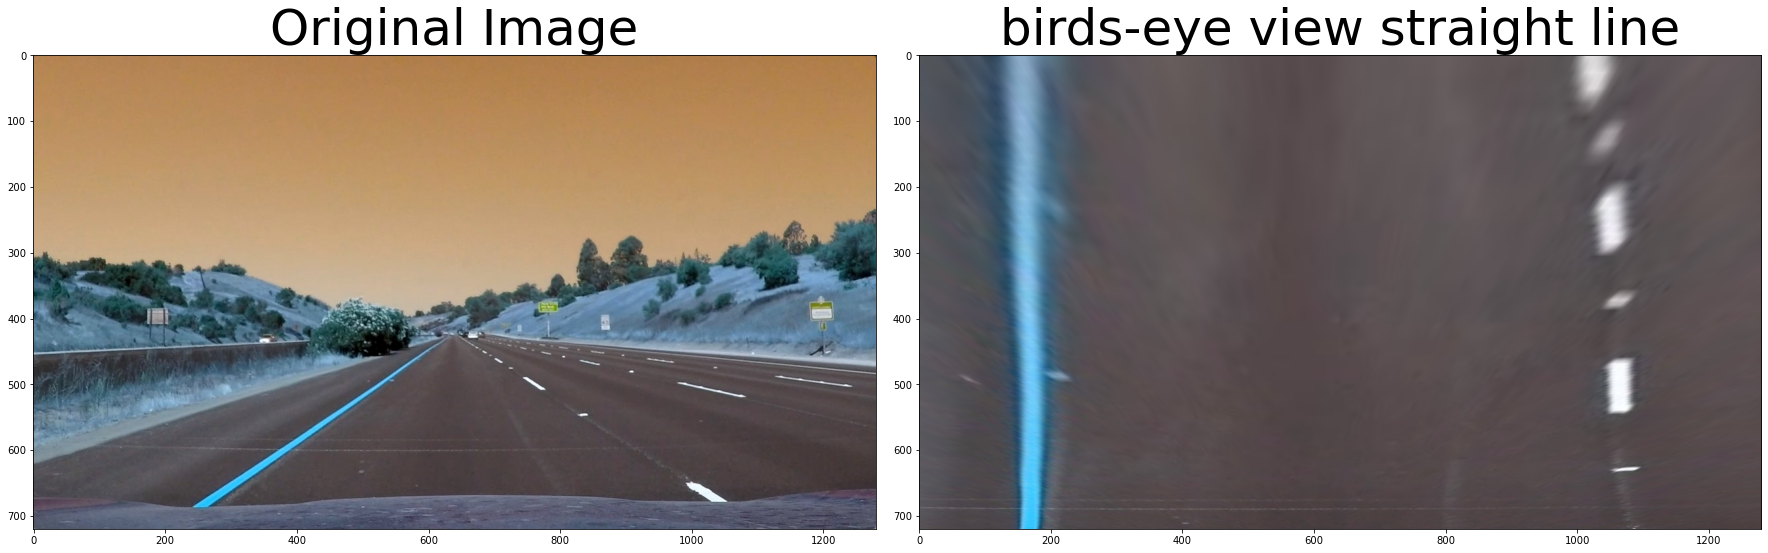

In [201]:
img = cv2.imread('test_images/straight_lines1.jpg')

gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
# My choice of 200 pixels is not exact, but close enough for our purpose here
offset = 0 # offset for dst points
# Grab the image shape
img_size = (gray.shape[1], gray.shape[0])

# For source points I'm grabbing the outer four detected corners
src = np.float32([[580,450],[710,450],[1150,650],[180,650] ])
# For destination points, I'm arbitrarily choosing some points to be
# a nice fit for displaying our warped result 
# again, not exact, but close enough for our purposes
dst = np.float32([[offset, offset], [img_size[0]-offset, offset], 
                             [img_size[0]-offset, img_size[1]-offset], 
                             [offset, img_size[1]-offset]])
# Given src and dst points, calculate the perspective transform matrix
M = cv2.getPerspectiveTransform(src, dst)
Minv = cv2.getPerspectiveTransform(dst, src)
# Warp the image using OpenCV warpPerspective()
warped = cv2.warpPerspective(img, M, img_size)
cv2.imwrite('warped2.jpg',warped)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(warped)
ax2.set_title('birds-eye view straight line', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

draw lines on image...
write to pickle file >>> t_pickle.p
Visulize the result...


<ipython-input-314-f11e3b01cc0d>:3: DeprecationWarning: an integer is required (got type numpy.float32).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  cv2.line(img, tuple(src[0]), tuple(src[1]), [255,0,0], 2)
<ipython-input-314-f11e3b01cc0d>:4: DeprecationWarning: an integer is required (got type numpy.float32).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  cv2.line(img, tuple(src[1]), tuple(src[2]), [255,0,0], 2)
<ipython-input-314-f11e3b01cc0d>:5: DeprecationWarning: an integer is required (got type numpy.float32).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  cv2.line(img, tuple(src[2]), tuple(src[3]), [255,0,0], 2)
<ipython-input-314-f11e3b01cc0d>:6: DeprecationWarning: an integer is required (got type numpy.float32).  Implicit conversion to integers using __int__ is deprecated, an

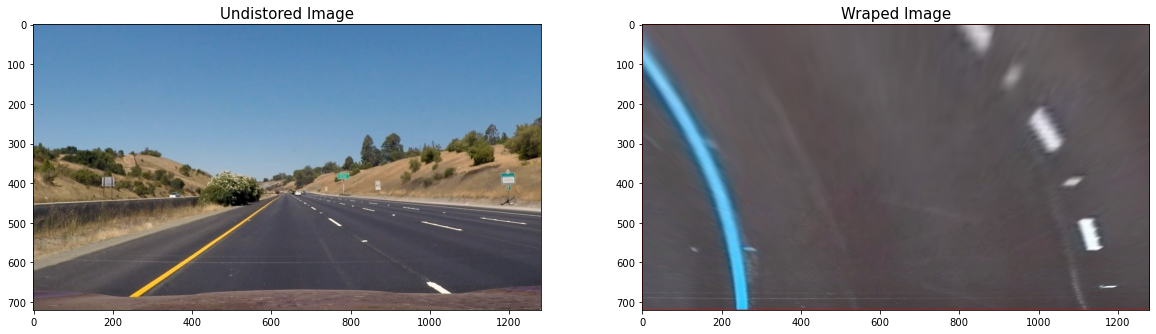

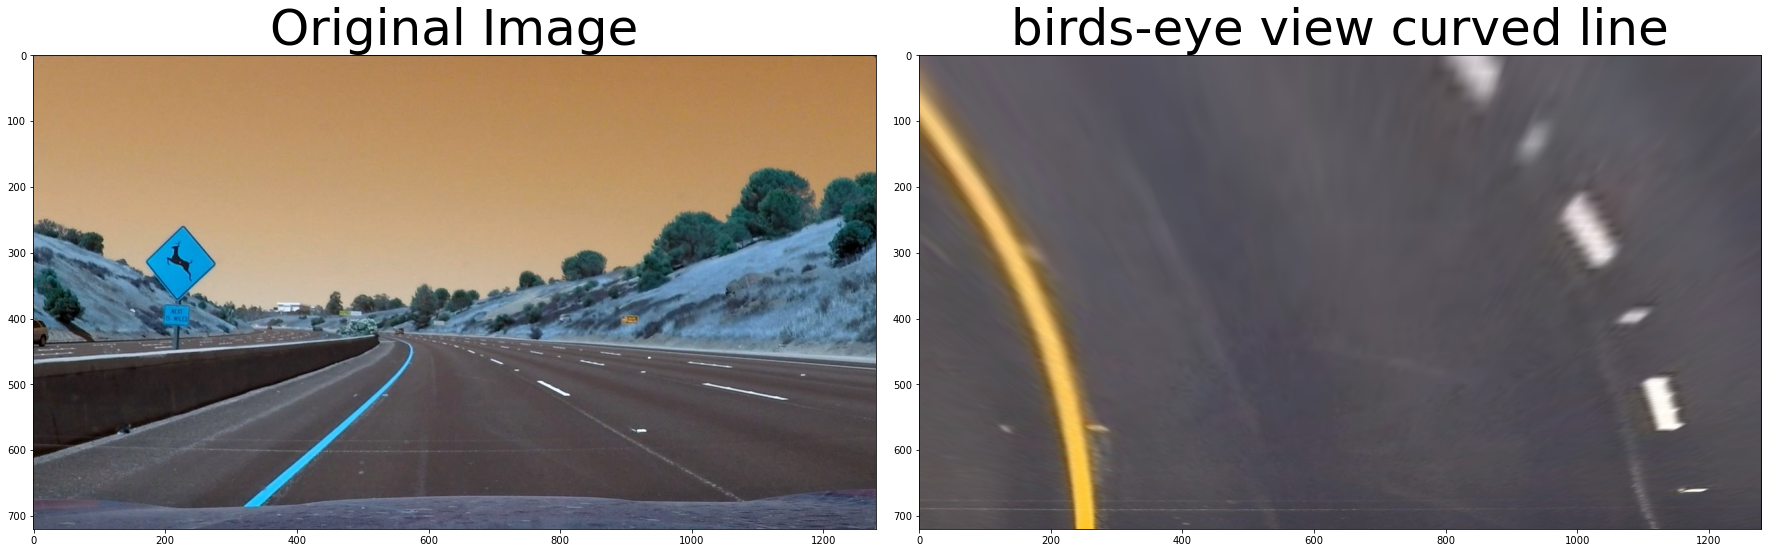

In [318]:
img = cv2.imread('test_images/test2.jpg')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
# My choice of 200 pixels is not exact, but close enough for our purpose here
offset = 0 # offset for dst points
# Grab the image shape
img_size = (gray.shape[1], gray.shape[0])

# For source points I'm grabbing the outer four detected corners
src = np.float32([[580,450],[710,450],[1150,650],[180,650] ])
# For destination points, I'm arbitrarily choosing some points to be
# a nice fit for displaying our warped result 
# again, not exact, but close enough for our purposes
dst = np.float32([[offset, offset], [img_size[0]-offset, offset], 
                             [img_size[0]-offset, img_size[1]-offset], 
                             [offset, img_size[1]-offset]])
# Given src and dst points, calculate the perspective transform matrix
Minv = cv2.getPerspectiveTransform(dst, src)
M = cv2.getPerspectiveTransform(src, dst)
# Warp the image using OpenCV warpPerspective()
warped = cv2.warpPerspective(img, M, img_size)
warped = cv2.cvtColor(warped, cv2.COLOR_RGB2BGR)
cv2.imwrite('warped.jpg',warped)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(warped)
ax2.set_title('birds-eye view curved line', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

draw lines on image...
write to pickle file >>> t_pickle.p
Visulize the result...


<ipython-input-319-f97f20045c04>:3: DeprecationWarning: an integer is required (got type numpy.float32).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  cv2.line(img, tuple(src[0]), tuple(src[1]), [255,0,0], 2)
<ipython-input-319-f97f20045c04>:4: DeprecationWarning: an integer is required (got type numpy.float32).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  cv2.line(img, tuple(src[1]), tuple(src[2]), [255,0,0], 2)
<ipython-input-319-f97f20045c04>:5: DeprecationWarning: an integer is required (got type numpy.float32).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  cv2.line(img, tuple(src[2]), tuple(src[3]), [255,0,0], 2)
<ipython-input-319-f97f20045c04>:6: DeprecationWarning: an integer is required (got type numpy.float32).  Implicit conversion to integers using __int__ is deprecated, an

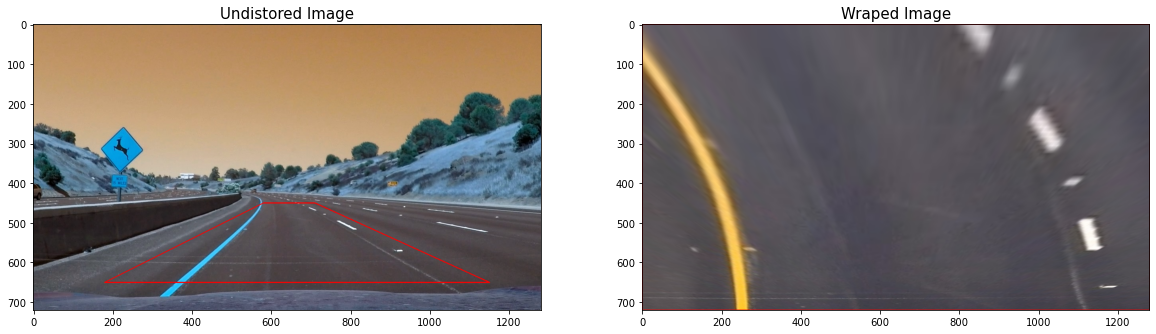

In [319]:
# draw 4 lines
print("draw lines on image...")
cv2.line(img, tuple(src[0]), tuple(src[1]), [255,0,0], 2)
cv2.line(img, tuple(src[1]), tuple(src[2]), [255,0,0], 2)
cv2.line(img, tuple(src[2]), tuple(src[3]), [255,0,0], 2)
cv2.line(img, tuple(src[3]), tuple(src[0]), [255,0,0], 2)

cv2.line(warped, tuple(dst[0]), tuple(dst[1]), [255,0,0], 2)
cv2.line(warped, tuple(dst[1]), tuple(dst[2]), [255,0,0], 2)
cv2.line(warped, tuple(dst[2]), tuple(dst[3]), [255,0,0], 2)
cv2.line(warped, tuple(dst[3]), tuple(dst[0]), [255,0,0], 2)

# write to pickle file
print("write to pickle file >>> t_pickle.p")
trans_pickle = {}
trans_pickle["M"] = M
trans_pickle["Minv"] = Minv 
pickle.dump(trans_pickle, open("t_pickle.p", "wb"))

print("Visulize the result...")
f, (ax1,ax2) = plt.subplots(1,2, figsize=(20,10))
ax1.imshow(img), ax1.set_title('Undistored Image', fontsize=15)
ax2.imshow(warped), ax2.set_title('Wraped Image', fontsize=15)
plt.show()

### Describe how (and identify where in your code) you identified lane-line pixels and fit their positions with a polynomial?

Methods have been used to identify lane line pixels in the rectified binary image. The left and right line have been identified and fit with a curved functional form (e.g., spine or polynomial). Example images with line pixels identified and a fit overplotted should be included in the writeup (or saved to a folder) and submitted with the project.

left_fit: [-4.89988949e-04  7.82636663e-01 -5.29524792e+01]
right_fit: [-2.04130812e-04  5.77730245e-01  8.78693891e+02]


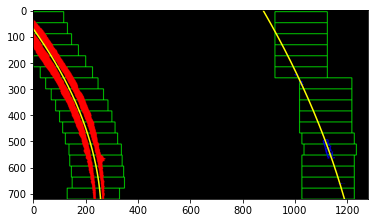

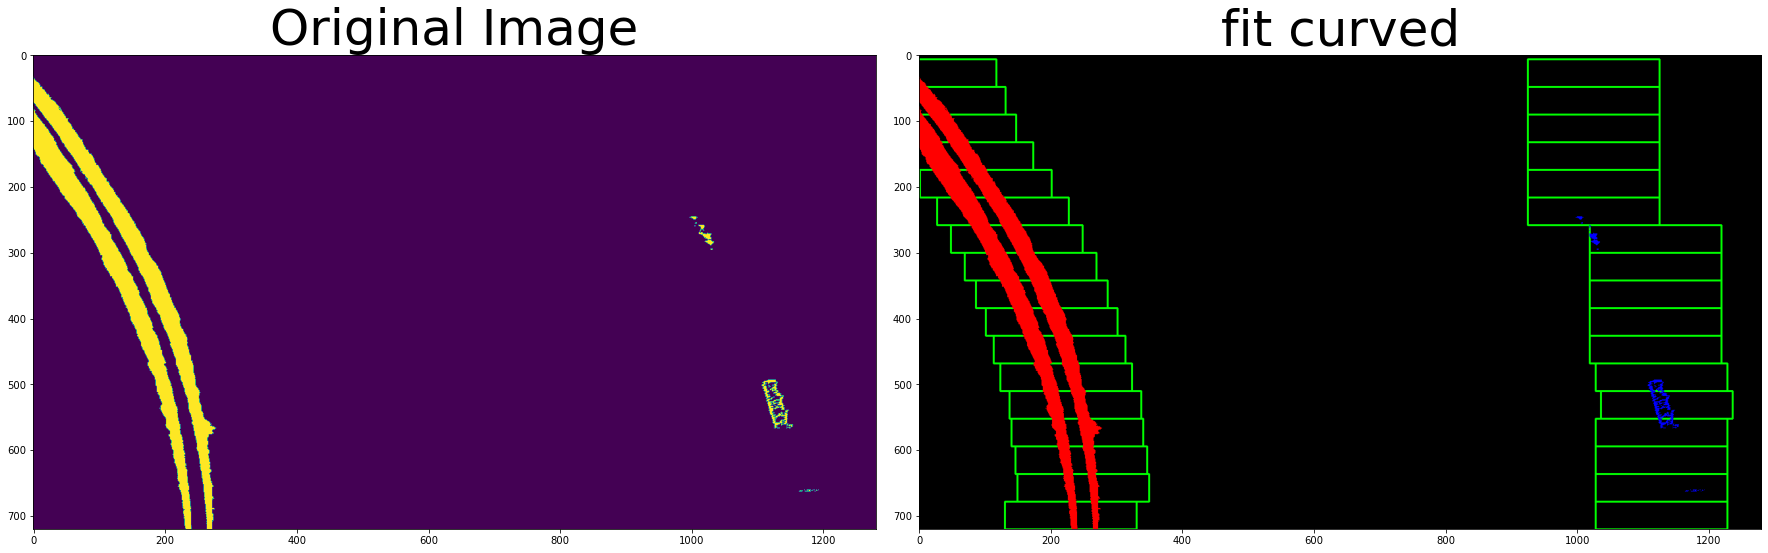

In [320]:
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import cv2

# Load our image
binary_warpedx = mpimg.imread('warped.jpg')

def hls_select(img, thresh=(0, 255)):
    # 1) Convert to HLS color space
    # 2) Apply a threshold to the S channel
    # 3) Return a binary image of threshold result
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    binary_output = np.zeros_like(s_channel)
    binary_output[(s_channel > thresh[0]) & (s_channel <= thresh[1])] = 1
    return binary_output
    
# Optional TODO - tune the threshold to try to match the above image!    
binary_warped = hls_select(binary_warpedx, thresh=(50, 200))

def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 17
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img


def fit_polynomial(binary_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

    # Fit a second order polynomial to each using `np.polyfit`
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    print("left_fit:",left_fit)
    print("right_fit:",right_fit)
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    # Plots the left and right polynomials on the lane lines
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')

    return out_img


out_img = fit_polynomial(binary_warped)

plt.imshow(out_img)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(binary_warped)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(out_img)
ax2.set_title('fit curved', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

### Describe how (and identify where in your code) you calculated the radius of curvature of the lane and the position of the vehicle with respect to center.

Here the idea is to take the measurements of where the lane lines are and estimate how much the road is curving and where the vehicle is located with respect to the center of the lane. The radius of curvature may be given in meters assuming the curve of the road follows a circle. For the position of the vehicle, you may assume the camera is mounted at the center of the car and the deviation of the midpoint of the lane from the center of the image is the offset you're looking for. As with the polynomial fitting, convert from pixels to meters.

ploty shape :  (720,) leftx shape :  (33055,)
[-0.00163166  0.10859084 -0.30613152]


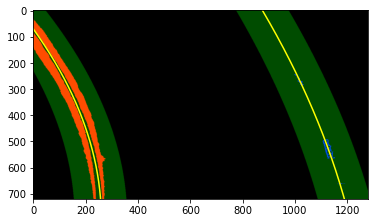

In [321]:
import cv2
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

# Load our image - this should be a new frame since last time!
#binary_warped = mpimg.imread('warped-example.jpg')
# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/640 # meters per pixel in x dimension
# Polynomial fit values from the previous frame
# Make sure to grab the actual values from the previous step in your project!
left_fit = np.array([ -4.90421067e-04,7.83310086e-01,-5.31463074e+01])
right_fit = np.array([-2.36039952e-04,6.03098681e-01,8.74195123e+02])

def fit_poly(img_shape, leftx, lefty, rightx, righty):
     ### TO-DO: Fit a second order polynomial to each with np.polyfit() ###
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
   
    
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    print("ploty shape : ",ploty.shape,"leftx shape : ",leftx.shape)
    #Fit new polynomials to x,y in world space
    #left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    #right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
    
    ### TO-DO: Calc both polynomials using ploty, left_fit and right_fit ###
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    # x= mx / (my ** 2) *a*(y**2)+(mx/my)*b*y+c
     # convert to meter
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    #left_fit_cr = xm_per_pix/(ym_per_pix**2)*left_fit[0]*ploty**2 + (xm_per_pix/ym_per_pix)*left_fit[1]*ploty + left_fit[2]
    #right_fit_cr = xm_per_pix/(ym_per_pix**2)*right_fit[0]*ploty**2 + (xm_per_pix/ym_per_pix)*right_fit[1]*ploty + right_fit[2]
    
    
    return left_fitx, right_fitx, ploty,left_fit_cr,right_fit_cr

def search_around_poly(binary_warped):
    # HYPERPARAMETER
    # Choose the width of the margin around the previous polynomial to search
    # The quiz grader expects 100 here, but feel free to tune on your own!
    margin = 100

    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    ### TO-DO: Set the area of search based on activated x-values ###
    ### within the +/- margin of our polynomial function ###
    ### Hint: consider the window areas for the similarly named variables ###
    ### in the previous quiz, but change the windows to our new search area ###
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                    left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin)))
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit new polynomials
    left_fitx, right_fitx, ploty,left_fit_cr,right_fit_cr = fit_poly(binary_warped.shape, leftx, lefty, rightx, righty)
    print(left_fit_cr)
    ## Visualization ##
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    # Plot the polynomial lines onto the image
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    ## End visualization steps ##
    
    return result,left_fit_cr,right_fit_cr,ploty

# Run image through the pipeline
# Note that in your project, you'll also want to feed in the previous fits
result,left_fit_cr,right_fit_cr,ploty= search_around_poly(binary_warped)

# View your output
plt.imshow(result)

In [281]:
xm_per_pix//ym_per_pix**2



3.0

In [322]:
def measure_curvature_pixels(left_fit, right_fit,ploty):
    '''
    Calculates the curvature of polynomial functions in pixels.
    '''
    # Start by generating our fake example data
    # Make sure to feed in your real data instead in your project!
    #ploty, left_fit, right_fit = generate_data()
    
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    
    # Calculation of R_curve (radius of curvature)
    left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    print(np.max(left_fit))
    return left_curverad, right_curverad


# Calculate the radius of curvature in pixels for both lane lines
left_curverad, right_curverad = measure_curvature_pixels(left_fit_cr, right_fit_cr,ploty)

print(left_curverad, right_curverad)



0.10859083701585785
4512.097015973387 1817.825824923107


In [326]:
def measure_curvature_real(left_fitx, right_fitx,ploty):
    '''
    Calculates the curvature of polynomial functions in meters.
    '''
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    # Start by generating our fake example data
    # Make sure to feed in your real data instead in your project!
    #ploty, left_fit, right_fit = fit_poly(ym_per_pix, xm_per_pix)
    
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    
    # Calculation of R_curve (radius of curvature)
    left_curverad = ((1 + (2*left_fitx[0]*y_eval*ym_per_pix + left_fitx[1])**2)**1.5) / np.absolute(2*left_fitx[0])
    right_curverad = ((1 + (2*right_fitx[0]*y_eval*ym_per_pix + right_fitx[1])**2)**1.5) / np.absolute(2*right_fitx[0])
    curverad = (left_curverad+right_curverad)/2
    return left_curverad, right_curverad, curverad


# Calculate the radius of curvature in meters for both lane lines
left_curverad, right_curverad,curverad = measure_curvature_real(left_fit_cr, right_fit_cr,ploty)

print(left_curverad, 'm', right_curverad, 'm','Avg Curverad', curverad )

306.4896732640933 m 706.6843405637264 m Avg Curverad 506.5870069139099


### Provide an example image of your result plotted back down onto the road such that the lane area is identified clearly.

The fit from the rectified image has been warped back onto the original image and plotted to identify the lane boundaries. This should demonstrate that the lane boundaries were correctly identified. An example image with lanes, curvature, and position from center should be included in the writeup (or saved to a folder) and submitted with the project.

In [346]:
# Create an image to draw the lines on
 
warp_zero = np.zeros_like(warped).astype(np.uint8)
color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

# Recast the x and y points into usable format for cv2.fillPoly()
pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
pts = np.hstack((pts_left, pts_right))

# Draw the lane onto the warped blank image
cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

# Warp the blank back to original image space using inverse perspective matrix (Minv)
newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 
# Combine the result with the original image
result = cv2.addWeighted(img, 1, newwarp, 0.3, 0)
plt.imshow(result)

error: OpenCV(4.4.0) C:\Users\appveyor\AppData\Local\Temp\1\pip-req-build-i2wttlgp\opencv\modules\core\src\array.cpp:3229: error: (-215:Assertion failed) cn <= 4 in function 'cv::scalarToRawData'


In [336]:
color_warp.shape

(720, 1280, 9)

In [334]:
newwarp.shape

(720, 1280, 9)